# Bayesian inference using Markov Chain Monte Carlo

In [2]:
import numpy as np
import scipy.stats as st

# generate observed data
X = st.norm(loc=3, scale=1).rvs(size=1000)  # rvs means?


In [3]:
def guassian_posterior(X, theta):
    # returns the unnormalized log posterior
    loglik = np.sum(np.log(st.norm(loc=theta, scale=1).pdf(X)))
    logprior = np.log(st.norm(loc=0, scale=1).pdf(theta))
    
    return loglik + logprior
    
def guassian_proposal(theta_curr):
    # proposal based on Gaussian
    theta_new = st.norm(loc=theta_curr, scale=0.2).rvs()
    return theta_new

def guassian_proposal_prob(x1, x2):
    # calculate proposal probability q(x2|x1), based on Gaussian
    q = st.norm(loc=x1, scale=1).pdf(x2)
    return q

def mcmc_mh_posterior(X, theta_init, func, proposal_func, proposal_func_prob, n_iter=1000):
    # Metropolis-Hastings to estimate posterior
    thetas = []
    theta_curr = theta_init
    accept_rates = []
    accept_cum = 0
    
    for i in range(1, n_iter+1):
        theta_new = proposal_func(theta_curr)
        
        prob_curr = func(X, theta_curr)
        prob_new = func(X, theta_new)
        
        # we calculate the prob=exp(x) only when prob<1 so the exp(x) will not overflow for large x
        if prob_new > prob_curr:
            acceptance_ratio = 1
        else:
            qr = proposal_func_prob(theta_curr, theta_new)/proposal_func_prob(theta_curr, theta_new)
            acceptance_ratio = np.exp(prob_new - prob_curr) * qr
        acceptance_prob = min(1, acceptance_ratio)
        
        if acceptance_prob > st.uniform(0,1).rvs():
            theta_curr = theta_new
            accept_cum = accept_cum+1
            thetas.append(theta_new)
        else:
            thetas.append(theta_curr)
            
        accept_rates.append(accept_cum/i)
        
    return thetas, accept_rates

# run MCMC
thetas, accept_rates = mcmc_mh_posterior(X, 1, 
                                         guassian_posterior, guassian_proposal, guassian_proposal_prob, 
                                         n_iter=8000)

Mean acceptance rate:  0.208


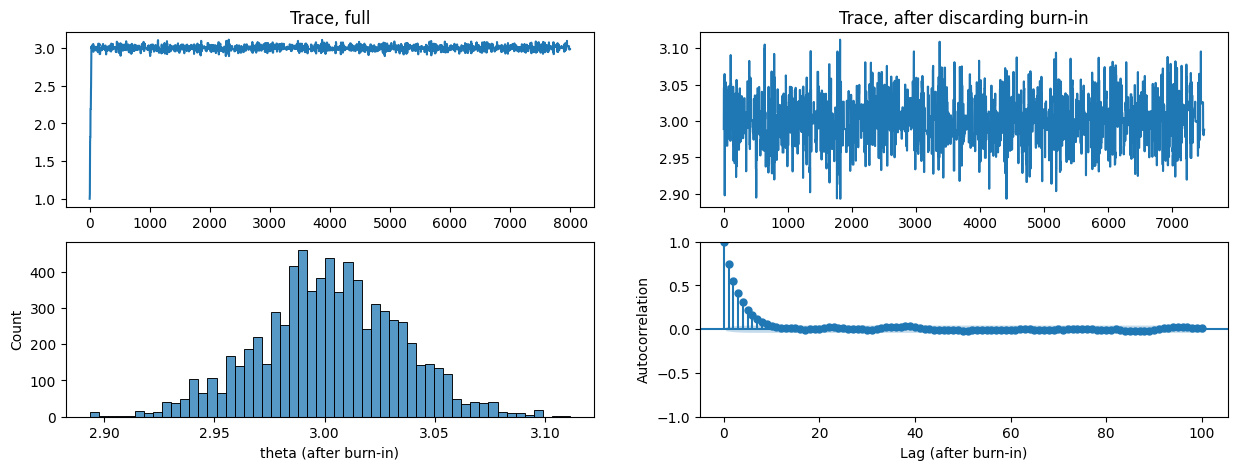

In [5]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import seaborn as sns

def plot_res(xs, burn_in, x_name):
    # plot trace (based on xs), distribution, and autocorrelation

    xs_kept = xs[burn_in:]
    
    # plot trace full
    fig, ax = plt.subplots(2,2, figsize=(15,5))
    ax[0,0].plot(xs)
    ax[0,0].set_title('Trace, full')
    
    # plot trace, after burn-in
    ax[0,1].plot(xs_kept)
    ax[0,1].set_title('Trace, after discarding burn-in')

    # plot distribution, after burn-in
    sns.histplot(xs_kept, ax=ax[1,0])
    ax[1,0].set_xlabel(f'{x_name} (after burn-in)')
    
    # plot autocorrelation, after burn-in
    plot_acf(np.array(xs_kept), lags=100, ax=ax[1,1], title='')
    ax[1,1].set_xlabel('Lag (after burn-in)')
    ax[1,1].set_ylabel('Autocorrelation')

plot_res(thetas, 500, 'theta')
print(f"Mean acceptance rate: {np.mean(accept_rates[500:]): .3f}")

## Resources

* https://boyangzhao.github.io/posts/mcmc-bayesian-inference